In [1]:
import os
from pprint import *
import googleapiclient.discovery
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil import parser
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
channels = pd.read_csv('csv/channels.csv', index_col=0)
videos = pd.read_csv('csv/videos.csv', index_col = 0, sep =';')

In [3]:
channels = channels[channels.channelId != "UCCCPCZNChQdGa9EkATeye4g"]
videos = videos[videos.channelId != "UCCCPCZNChQdGa9EkATeye4g"]

In [12]:
videos_m = pd.merge(videos, channels, left_on="channelId", right_on="channelId", how="left")

In [13]:
videos_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11937 entries, 0 to 11936
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   channelId         11937 non-null  object 
 1   videoId           11937 non-null  object 
 2   publishedAt_x     11937 non-null  object 
 3   publishedYear     11937 non-null  float64
 4   publishedMonth    11937 non-null  float64
 5   publishedDay      11937 non-null  float64
 6   publishedWeekday  11937 non-null  float64
 7   publishedHour     11937 non-null  float64
 8   title_x           11937 non-null  object 
 9   viewCount_x       11937 non-null  int64  
 10  likeCount         11793 non-null  float64
 11  commentCount      11911 non-null  float64
 12  title_y           11937 non-null  object 
 13  publishedAt_y     11937 non-null  object 
 14  viewCount_y       11937 non-null  int64  
 15  subscriberCount   11937 non-null  int64  
 16  videoCount        11937 non-null  int64 

## Compute engagement per video

In [14]:
videos_m = videos_m.rename(columns={
    'publishedAt_x': 'publishedAt_video',
    'title_x': 'title_video',
    'viewCount_x': 'viewCount_video',
    'title_y': 'title_channel',
    'viewCount_y': 'viewCount_channel'
}
                                                    )

In [15]:
videos_m = videos_m.assign(
    #engagement_1 = (((videos_m.likeCount + videos_m.commentCount) / videos_m.videoCount) / videos_m.subscriberCount) * 100,
    engagement = ((videos_m.likeCount + videos_m.commentCount) / videos_m.subscriberCount) * 100,
    #engagement_3 = (((videos_m.likeCount + videos_m.commentCount + videos_m.viewCount_video) / videos_m.videoCount) / videos_m.subscriberCount) * 100,
    #engagement_4 = ((videos_m.likeCount + videos_m.commentCount + videos_m.viewCount_video) / videos_m.subscriberCount) * 100,
    #engagement_5 = (videos_m.viewCount_video + videos_m.likeCount + videos_m.commentCount) / videos_m.subscriberCount
    
) 

<AxesSubplot:xlabel='engagement', ylabel='title_channel'>

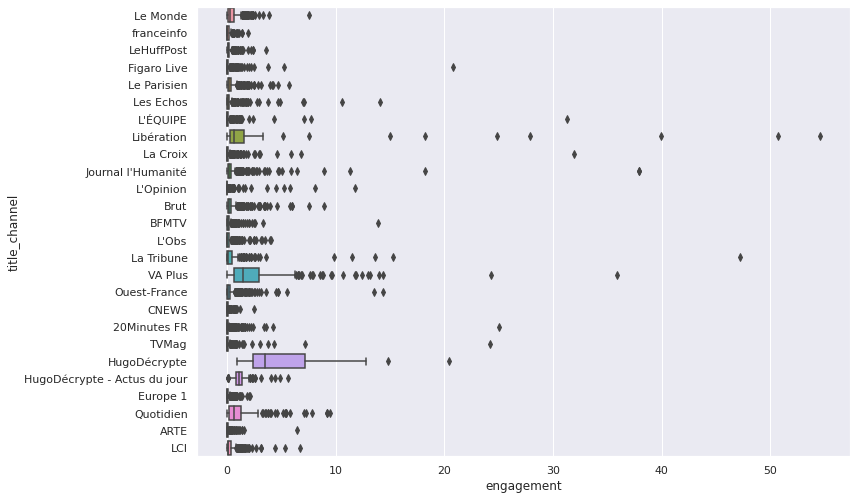

In [16]:
sns.boxplot(
    x = 'engagement',
    y = 'title_channel',
    data = videos_m
)

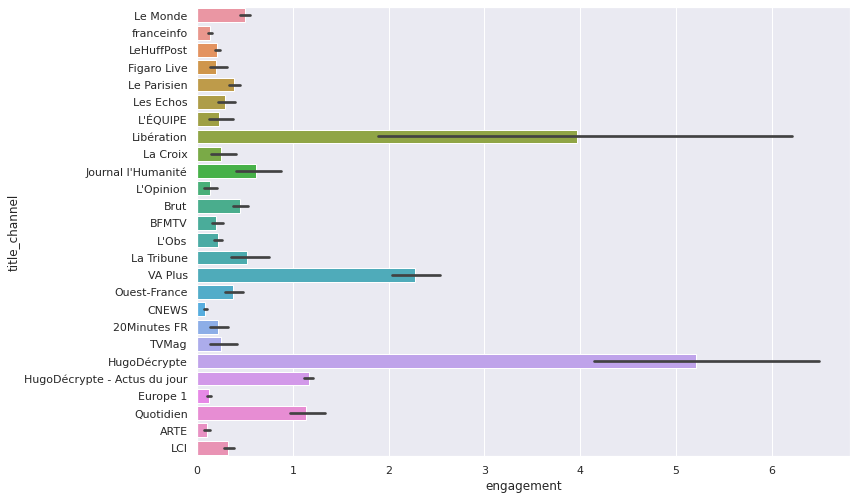

In [17]:
ax = sns.barplot(y="title_channel", x="engagement", data=videos_m)

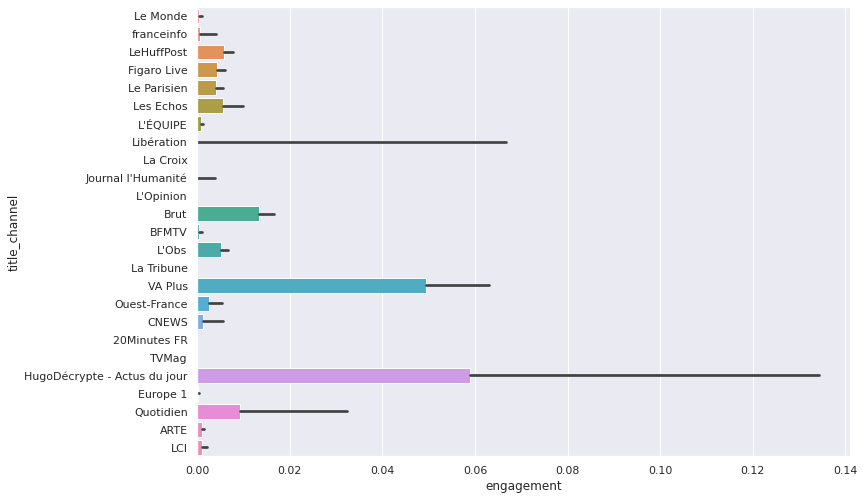

In [18]:
ax = sns.barplot(y="title_channel", x="engagement", data=videos_m[videos_m.title_channel != "HugoDécrypte"], estimator=min )

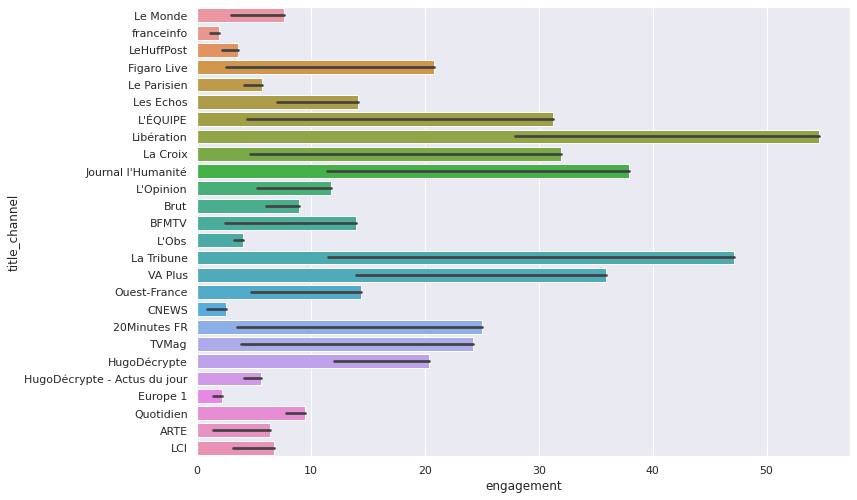

In [19]:
ax = sns.barplot(y="title_channel", x="engagement", data=videos_m, estimator=max)

In [20]:
def add_labels(x, y, labels, ax=None):
    """Ajoute les étiquettes `labels` aux endroits définis par `x` et `y`."""

    if ax is None:
        ax = plt.gca()
    for x, y, label in zip(x, y, labels):
        ax.annotate(
            label, [x, y], xytext=(10, -5), textcoords="offset points",
        )

    return ax

In [21]:
channelquant = channels[["publishedAt","viewCount","subscriberCount", "videoCount"]]
channelquant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 26
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   publishedAt      26 non-null     object
 1   viewCount        26 non-null     int64 
 2   subscriberCount  26 non-null     int64 
 3   videoCount       26 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.0+ KB


In [22]:
channelquant.publishedAt = channelquant.publishedAt.str[:4]
channelquant.publishedAt = channelquant.publishedAt.astype(int)

/home/romain/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [23]:
channelquant = channelquant - channelquant.mean(axis=0)

In [24]:
sns.set(rc={'figure.figsize':(15,10)})

cls = PCA(n_components=3)
pcs = cls.fit_transform(channelquant)

channelPCA = pd.DataFrame(pcs, columns=["Comp1", "Comp2", "Comp3"])
channelPCA.index = channelquant.index

<AxesSubplot:xlabel='Comp1', ylabel='Comp2'>

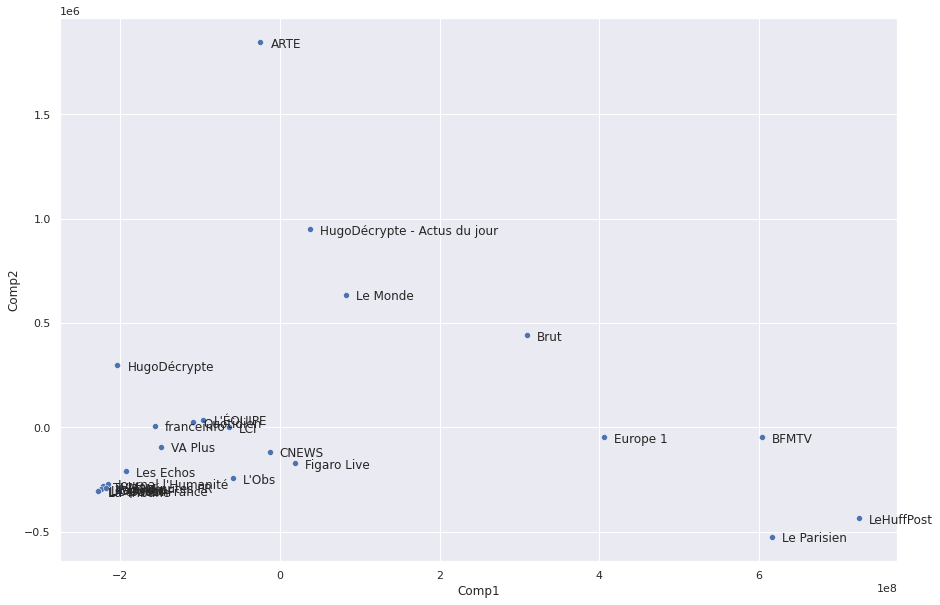

In [25]:
sns.scatterplot(x = "Comp1", y = "Comp2", data = channelPCA)
add_labels(channelPCA['Comp1'], channelPCA['Comp2'], channels.title)

<AxesSubplot:xlabel='Comp2', ylabel='Comp3'>

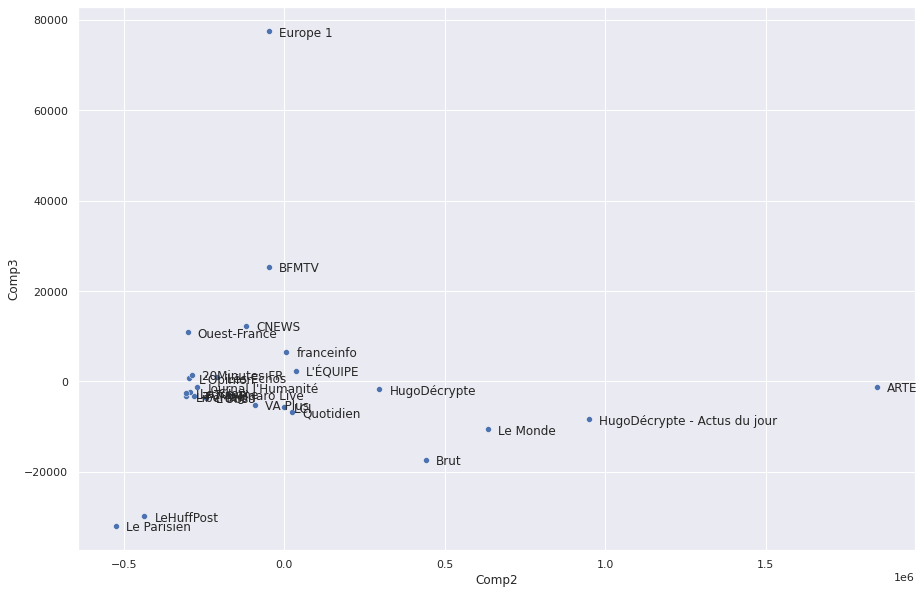

In [26]:
sns.scatterplot(x = "Comp2", y = "Comp3", data = channelPCA)
add_labels(channelPCA['Comp2'], channelPCA['Comp3'], channels.title)

In [27]:
pprint(cls.components_)

array([[-1.32069949e-10,  9.99999262e-01,  1.21438900e-03,
         4.33149836e-05],
       [ 7.71426723e-07, -1.21418389e-03,  9.99989331e-01,
        -4.45688713e-03],
       [-9.78555235e-05, -4.87269161e-05,  4.45683131e-03,
         9.99990062e-01]])


## K-MEANS OF DOOOM

In [28]:
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, labels = None, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)
    
    if type(labels) != None:
        add_labels(data_pca[f"PC{pc1}"], data_pca[f"PC{pc2}"], labels) 
        
    return ax, pca

In [29]:
type(channels.title)

pandas.core.series.Series

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

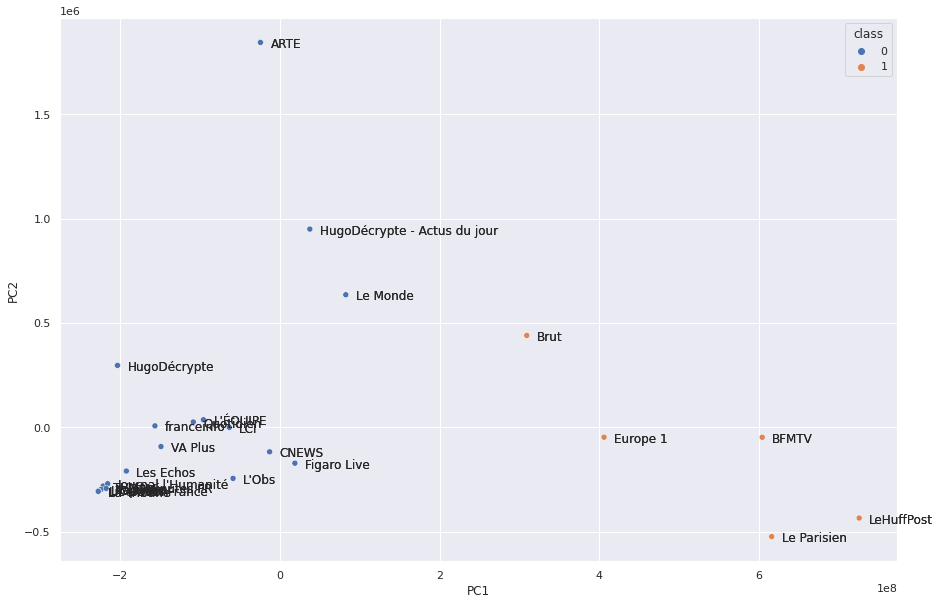

In [30]:
cls = KMeans(n_clusters=2, init="k-means++").fit(channelquant)
scatterplot_pca(
    columns=["publishedAt","viewCount","subscriberCount", "videoCount"], hue=cls.labels_, data=channelquant, labels = channels.title
)
add_labels(channelPCA['Comp1'], channelPCA['Comp2'], channels.title)

In [31]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

In [32]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    default_kwargs = dict(leaf_font_size=10)
    default_kwargs.update(kwargs or {})

    dendrogram(linkage_matrix, **default_kwargs)


In [33]:
cls = AgglomerativeClustering(linkage="ward", affinity="euclidean", distance_threshold=3, n_clusters=None)
cls.fit(channelquant)

AgglomerativeClustering(distance_threshold=3, n_clusters=None)

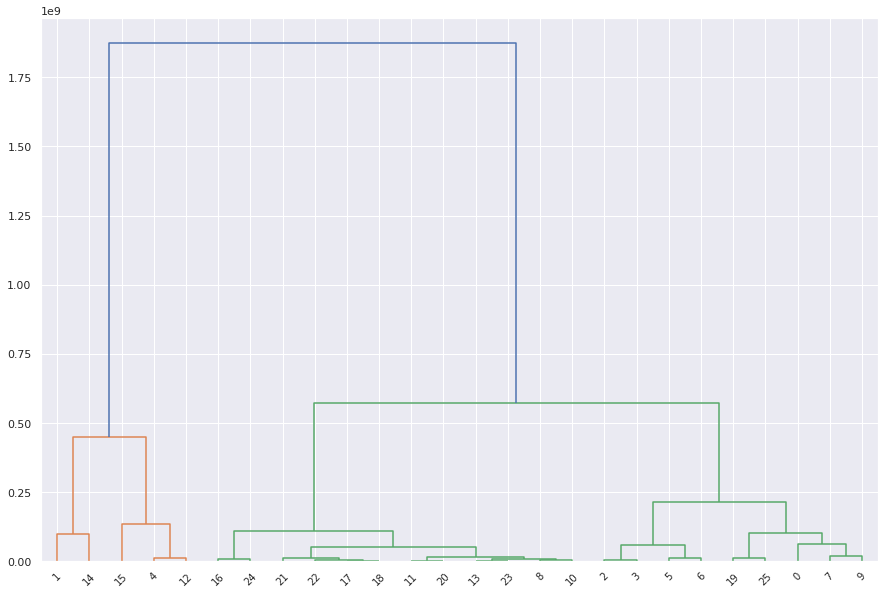

In [34]:
plot_dendrogram(cls)

In [35]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
X = pd.DataFrame(
    squareform(pdist(channelquant)),
    columns = channels.title,
    index = channels.title
)

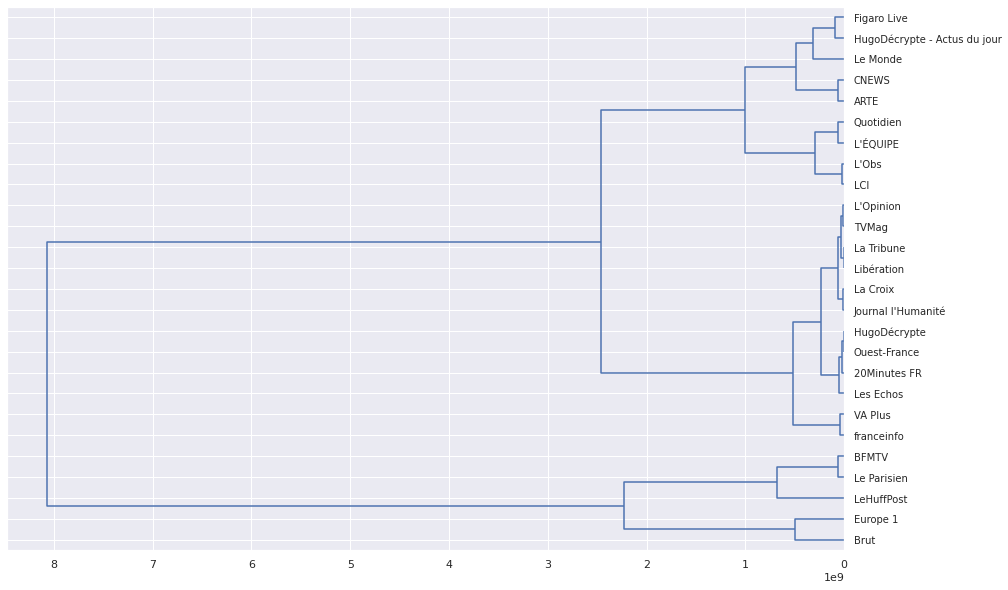

In [36]:
model = AgglomerativeClustering(
    linkage="ward", 
    affinity="euclidean", 
    distance_threshold=0, 
    n_clusters=None
).fit(X)

plot_dendrogram(model,color_threshold=1, labels=X.index,orientation="left")

/home/romain/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

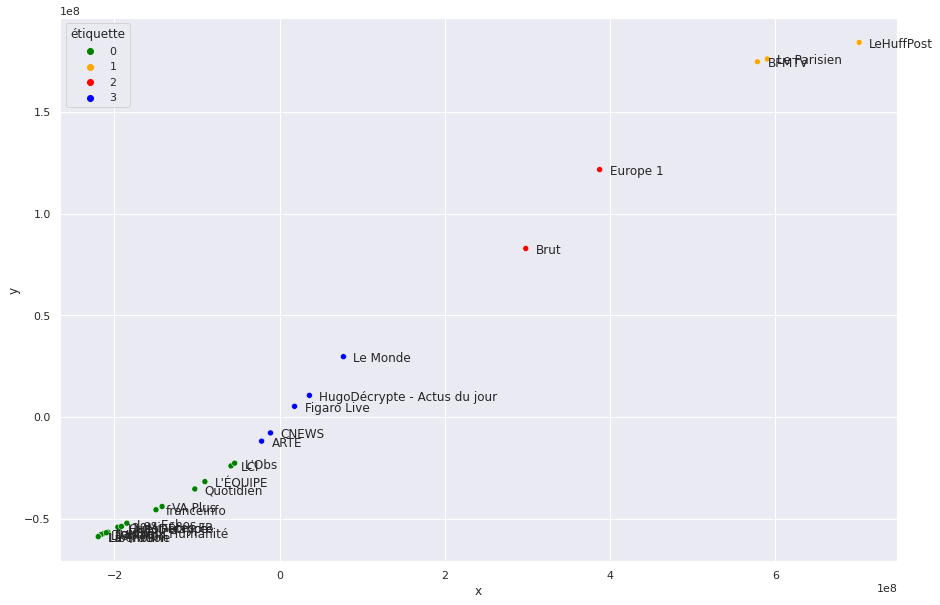

In [37]:
model = AgglomerativeClustering(
    affinity="precomputed", linkage="complete", n_clusters=4
).fit(X)

labels = model.labels_

aftd = MDS(n_components=2, dissimilarity="precomputed")
dist = aftd.fit_transform(X)

df = pd.DataFrame({"x": dist[:, 0], "y": dist[:, 1], "étiquette":labels})

sns.scatterplot("x", "y", hue="étiquette", data=df,
               palette=['green','orange','red','blue'], legend='full')
add_labels(dist[:, 0], dist[:, 1], X.index)

# VIDEOOOOOS

In [38]:
hdadj = videos_m[videos_m.title_channel == "HugoDécrypte - Actus du jour"]
hdadj = hdadj[hdadj.publishedYear == 2022]

<AxesSubplot:xlabel='publishedAt_video', ylabel='engagement'>

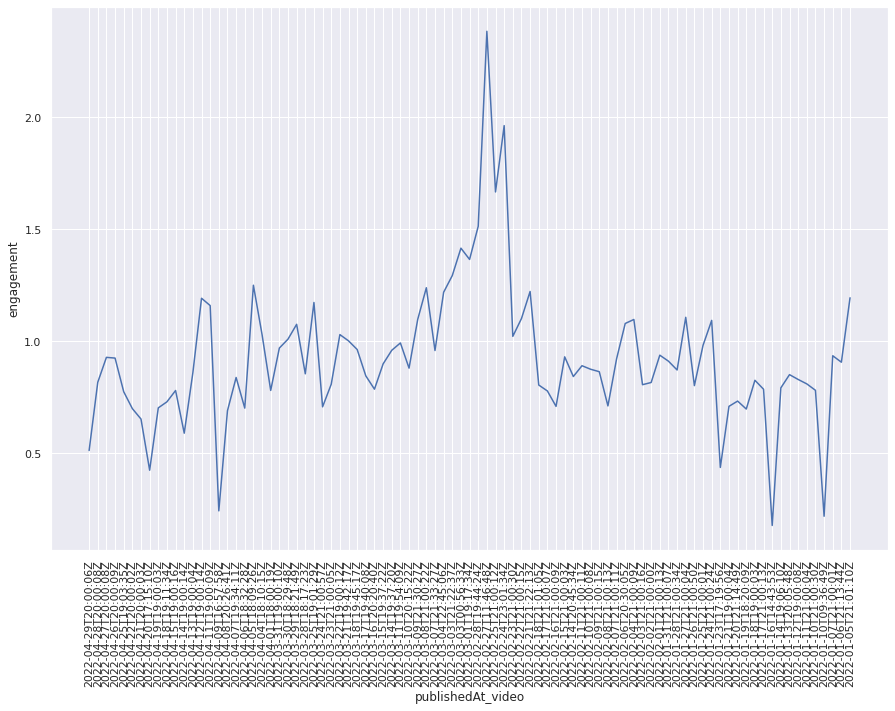

In [39]:
plt.xticks(rotation = 'vertical')
sns.lineplot(
    x = "publishedAt_video",
    y = "engagement",
    data = hdadj
)

# NLP

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import os
import sys
from tqdm import tqdm
import re
import pickle
import os
from pprint import *
import googleapiclient.discovery
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil import parser
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [14]:
print("No pre-computed stems found. Recomputing them...")
nltk.download('stopwords')
nltk.download("punkt")


titles = videos['title'].str.cat(sep=" ").lower()
tokens = re.split("; |, |-|\n|\(|\)| |&|\.\.\.|\?|!|¿|'|[0-9]|/|\.+|\+|#|%|\"|\*",titles)

print("Removing stopwords and stemming...")
snowball_stemmer = SnowballStemmer('french')
stemmed_tokens = [
    snowball_stemmer.stem(word) 
    for word in tokens
    if not word in stopwords.words() 
    and word != ''
    and len(word) > 1
]
stemmed_no_duplicates = np.unique(stemmed_tokens)

No pre-computed stems found. Recomputing them...
Removing stopwords and stemming...


[nltk_data] Downloading package stopwords to /home/romain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/romain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
with open('stemmed_no_duplicates.pckl', 'wb') as fp:
        pickle.dump(stemmed_no_duplicates, fp)
with open('stemmed_tokens.pckl', 'wb') as fp:
        pickle.dump(stemmed_tokens, fp)

In [5]:
STEMS_PATH = "./stemmed_no_duplicates.pckl"
STEMS_WITH_DUP = "./stemmed_tokens.pckl"

print("Loading pre-computed stems...")

with open(STEMS_PATH,"rb") as f:
    stemmed_no_duplicates = pickle.load(f)
    
with open(STEMS_WITH_DUP,"rb") as f:
    stemmed_tokens = pickle.load(f)

Loading pre-computed stems...


In [ ]:
stem_counts = pd.Series(stemmed_tokens).value_counts()
frequent_stems_counts = stem_counts[stem_counts >= 30]

from gensim.models import KeyedVectors

# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format('../../frwiki-20181020.treetag.2.ngram-pass2__2019-04-08_09.02__.s500_w5_skip.word2vec.bin', binary=True)

# available_stems = []
stems_embeddings = []
for word in list(frequent_stems_counts.index):
    if word in model.key_to_index:
        # available_stems.append(word) 
        stems_embeddings.append(model[word])

avail_freq_stems_counts = frequent_stems_counts[frequent_stems_counts.index.isin(model.key_to_index)]

stems_embeddings = np.array(stems_embeddings)
print("stems_embeddings shape =", stems_embeddings.shape)
print("their frequencies shape =", avail_freq_stems_counts.shape)